In [1]:
# pip install git+https://github.com/MIROptics/ECC2025.git

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.circuit.library import RawFeatureVector
from keras.layers import Dense
from keras import Input, Model

2025-01-09 16:58:01.653592: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 16:58:01.654100: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 16:58:01.656107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-09 16:58:01.661424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736452681.669867  163236 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736452681.67

Los __autoencoder__ son un tipo arquitectura de red neuronal para eficientemente comprimir y codificar datos. Estos están tipicamente divididos en tres capas, como podemos ver en la siguiente figura.

La primera capa, llamada __capa de entrada__, es donde introducimos nuestros datos. Luego la data pasa a través de un encoder y viaja a la siguiente capa, la cual tiene menos nodos que la capa de entrada. Esto produce una reducción en la dimensión de los datos, por lo que es llamada __capa bottleneck__ (cuello de botella). Un autoencoder puede tener varias de estas capas. Finalmente los datos comprimidos pasan a la __capa de salida__. Acá los datos son restaurados a su tamaño original por un proceso de decodificación.

De este modo, los autoencoder permiten la reducción de dimensión de los datos de entrada mientras manteniendo lo más posible de su información. Debido a esto, los autoencoder son tipicamente utilizados para reducción de ruido, detección de anomalías, reconocimiento facial y modelos generativos [].

En analogía a los autoencoders clásicos, los autoencoder cuánticos pueden usarse para comprimir información cuántica. Acá cada qubit representa un nodo de la red neuronal, mientras que transformaciones unitarias representan las conexiones entre los nodos, tal como se ve en la figura.

Consideremos que tenemos datos de entrada representados por un estado cuántico $|\psi\rangle$ de $n+k$ qubits. Mediante una evolución unitaria $U$ y mediciones en los primeros $k$ qubits, transformamos este estado en un estado producto $|0\cdots0\rangle|\psi'\rangle$, donde $|0\cdots0\rangle$ es un estado de $k$ qubits y $|\psi'\rangle$ es un nuevo estado cuántico de $n$ qubits. De este modo logramos comprimir la información, pues pasamos de un estado de $n+k$ qubits a un estado de solo $n$ qubits. Luego, mediente otra transformación unitaria $V$ recuperamos el tamaño original de los datos.

El entrenamiento del autoencoder cuántico consiste en encontrar las unitarias $U(\theta)$ de codificación y $V(\theta)$ de decodificación, ambas representadas por circuitos cuánticos paramétricos. Esto se puede realizar maximizando la probabilidad de obtener el resultado $|0\cdots0\rangle$ en las medidas intermedias, es decir,
\begin{equation}
 F(\theta) = \langle \psi | U(\theta)^\dagger\left( |0\cdots 0\rangle\langle 0\cdots0|\otimes I \right) U(\theta)|\psi\rangle .
\end{equation}
El decodificador viene dado por el adjunto del codificador, es decir $V(\theta)=U(\theta)^\dagger$.

__Problema:__ Consideremos que queremos comprimir una imagen. La escala de gris de cada pixel de esta imagen esta guardada en el array ``image``. Construya un circuito cuántico de 4 qubits que codifique esta figura en la amplitud del estado cuántico. Esto se puede realizar utilizando la función ``RawFeatureVector`` de ``qiskit``.

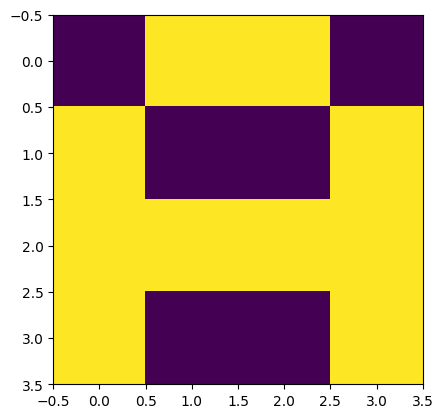

In [2]:
image = np.zeros( ( 2**2, 2**2 ) )
image[[1,2,3],[0,0,0]] = 1
image[[0,2,0,2],[1,1,2,2]] = 1
image[[1,2,3],[3,3,3]] = 1

plt.imshow(image, cmap='viridis')

(4, 4)


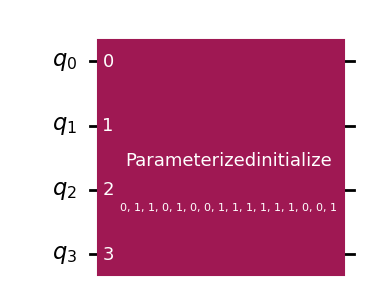

In [89]:
num_qubits = 4

qc_data = RawFeatureVector( 2**num_qubits )
qc_data = qc_data.assign_parameters( image.flatten() )

qc_data.draw('mpl')

__Problema:__ Construya el circuit cuántico paramétrico $U(\theta)$ de la siguiente figura para representar al codificador.

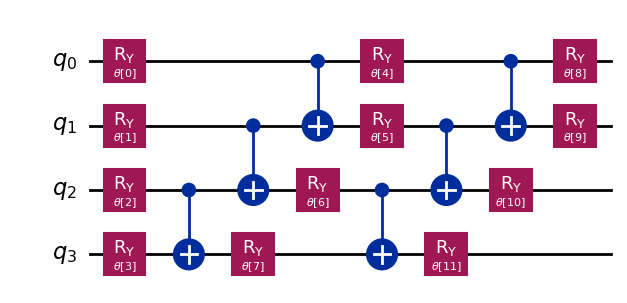

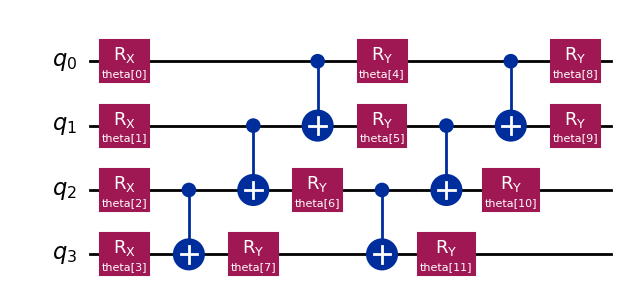

In [123]:
 # Se construye un circuito cuántico de 4 qubits
def autoencoder(num_qubits, reps):
    ae_qc = QuantumCircuit(num_qubits)

    # Definimos un conjunto de parámetros que serán ajustados
    theta = ParameterVector('theta', num_qubits * (reps+1))

    ####
    for q in range(num_qubits):
        ae_qc.rx(theta[q], q)   

    for r in range(1, reps+1):
        for q in range(0, num_qubits):
            if q > 0:
                ae_qc.cx(num_qubits - q - 1, num_qubits-q)
        
        for q in range(0, num_qubits):     
            ae_qc.ry(theta[num_qubits*r + q], q)
    return ae_qc

reps = 2
qc_encoder = autoencoder(num_qubits=num_qubits, reps=reps)
            
qc_encoder.draw('mpl',fold=-1)

__Problema:__ Construya una función que evalue la función objetivo $F(\theta)$. Esto requiere construir el circuito representado en la siguiente figura, ejecutarlo, y extraer el resultado asociado a $0\cdots0$.

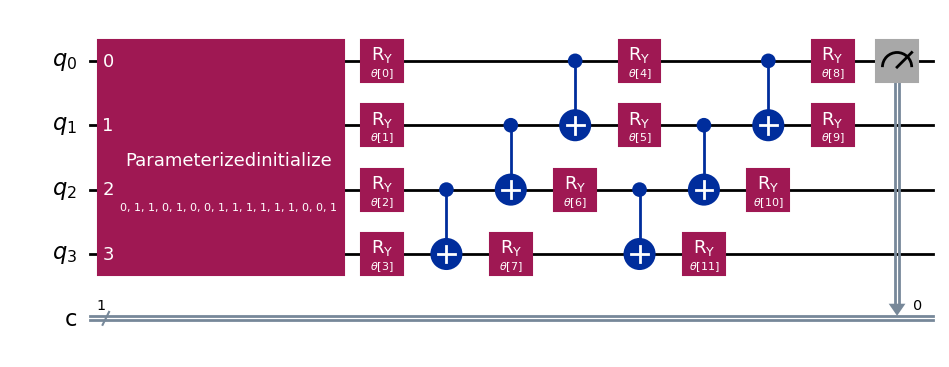

In [125]:
backend = Sampler()

num_qubits_trash = 1
num_qubits = 4
reps = 2

qc = QuantumCircuit(num_qubits, num_qubits_trash)
qc_data = RawFeatureVector( 2**num_qubits )
qc_data = qc_data.assign_parameters( image.flatten() )
qc.compose(qc_data, inplace = True)
qc.compose(qc_encoder, inplace=True)
qc.draw('mpl')
qc.measure(range(num_qubits_trash), range(num_qubits_trash))


def fun(params):
    job = backend.run(qc, params)    
    probs = job.result().quasi_dists[0].get(0,0)
    qc.draw('mpl')
    return 1-probs


In [126]:
xs = []
def callback(x):
    xs.append(fun(x))

optimizer = COBYLA( callback=callback, maxiter=300 )
num_params = (reps+1)*num_qubits
results   = optimizer.minimize( fun, np.zeros(num_params) )
params_opt = results.x
1-results.fun

np.float64(0.8984375)

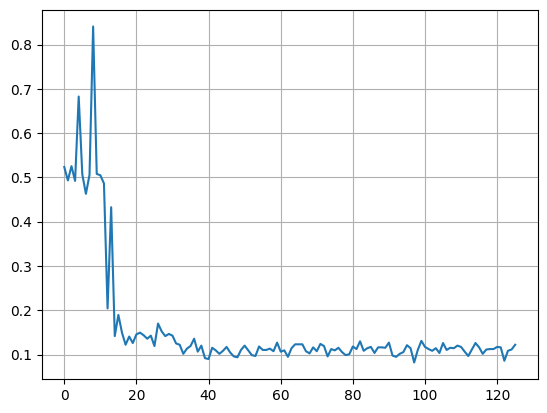

In [127]:
plt.plot( xs )
plt.grid()

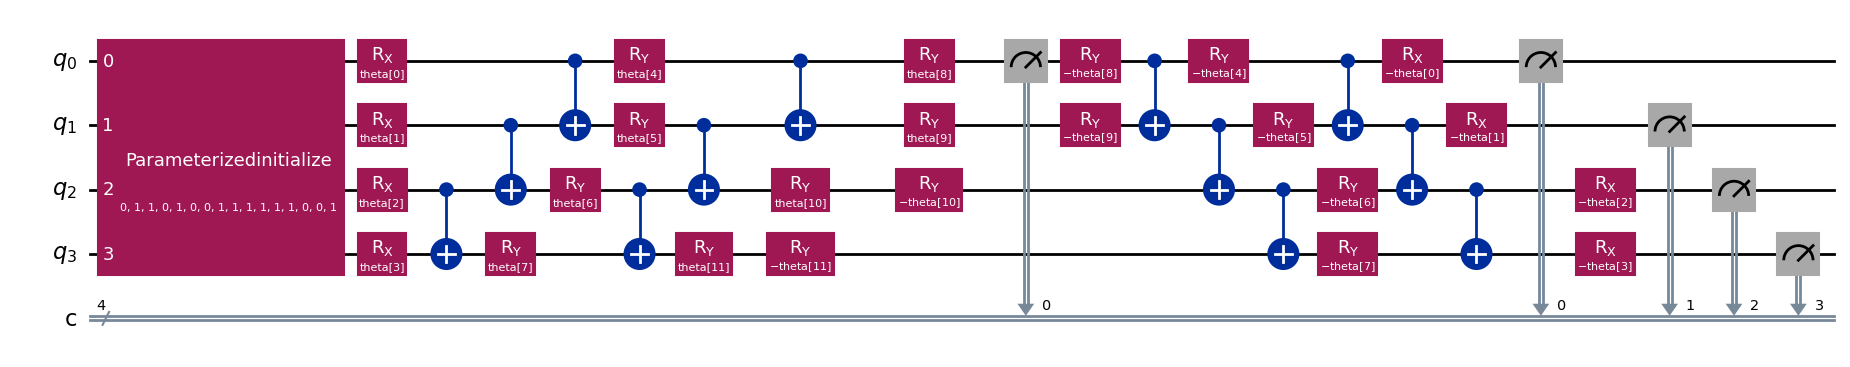

In [128]:
qc_decoder = QuantumCircuit( num_qubits, num_qubits )
qc_decoder.compose( qc, qubits=range(num_qubits), clbits=range(num_qubits_trash), inplace=True)
qc_decoder.compose( qc_encoder.inverse(), inplace=True )
qc_decoder.measure( range(num_qubits), range(num_qubits) )
qc_decoder.draw('mpl', fold=-1 )

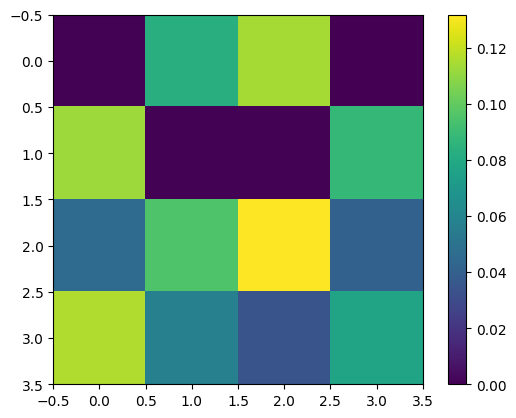

In [129]:
job   = backend.run( qc_decoder, params_opt )
probs = job.result().quasi_dists[0]

image_out = np.zeros(2**num_qubits)
for j in probs:
    image_out[j] = probs[j]
image_out = image_out.reshape(4,4)

plt.imshow( image_out )
plt.colorbar()

Entrenemos un autoencoder clásico para compararlo con su versión cuántica.

W0000 00:00:1736456578.802526  163236 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


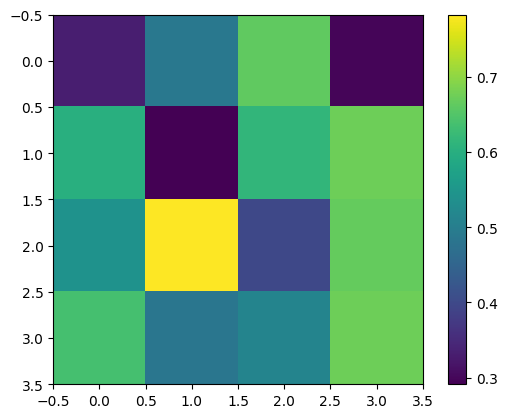

In [130]:
# Creamos modelo para el autoencoder
input_dim = 16
encoding_dim = 8
input_img = Input(shape=(input_dim,))
# Encoding
encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
# Decoding
decoded = Dense(input_dim, activation='sigmoid')(encoded)
# Modelo
autoencoder = Model(input_img, decoded)

# Este modelo es para ver la imagen decodificada
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Definimos optimizador y función objetivo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Entrenamiento
x = image.reshape(1,-1)
autoencoder.fit( x, x, epochs=100, verbose=0 )

# Graficando imagen decodificada
encoded_img = encoder.predict(x)
decoded_img = decoder.predict(encoded_img)
plt.imshow( decoded_img.reshape(4,4) )
plt.colorbar()

Por simplicidad, en este taller hemos estudiado la codificación de una única imagen. Si queremos comprimir un conjunto de imagenes con un autoencoder cuántico debemos recurrir al formalismo de las matrices densidad. En este caso cada imagen tendrá asociada un estado cuántico $|\psi_i\rangle$ con una probabilidad $p_i$, lo cual es conocido como un ensamble de estados puros. De este modo, la función objetivo vendrá dada por
\begin{equation*}
 F(\theta) =  {\rm Tr}\left[U(\theta) \rho U(\theta)^\dagger\left( |0\cdots 0\rangle\langle 0\cdots0|\otimes I \right) \right],
\end{equation*}
donde $\rho$ es la matriz densidad asociada con el ensamble de estados puros $\{ p_i, |\psi_i\rangle \}$,
\begin{equation*}
    \rho = \sum_i p_i |\psi_i\rangle\langle \psi_i |.
\end{equation*}
La preparación de matrices densidad se puede realizar de varias formas, entre las que tenemos el uso de qubit auxiliares, medidas intermedias, o muestreo.

In [131]:
# Importamos las librerías necesarias para trabajar con matrices densidad
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np

# Creamos un conjunto de estados puros con sus probabilidades
n_qubits = 4  # Número de qubits para representar nuestros estados
n_estados = 3  # Número de estados en el ensamble

# Generamos estados aleatorios y sus probabilidades
estados = []
probs = np.random.random(n_estados)
probs = probs / np.sum(probs)  # Normalizamos las probabilidades

for _ in range(n_estados):
    # Creamos estados aleatorios
    qc = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qc.ry(np.random.random() * 2 * np.pi, i)
        qc.rz(np.random.random() * 2 * np.pi, i)
    
    # Convertimos el circuito a un estado puro
    estado = Statevector.from_instruction(qc)
    estados.append(estado)

# Construimos la matriz densidad
rho = DensityMatrix.from_ensemble([(p, e) for p, e in zip(probs, estados)])

# Creamos el circuito del autoencoder
qr = QuantumRegister(n_qubits, 'q')
cr = ClassicalRegister(n_qubits-2, 'c')  # Reducimos 2 qubits en la codificación
qc_encoder = QuantumCircuit(qr, cr)

# Agregamos capas de codificación
for i in range(n_qubits-1):
    qc_encoder.cnot(i, i+1)
    qc_encoder.ry(np.random.random() * 2 * np.pi, i)

# Medimos los qubits que representan el estado codificado
for i in range(n_qubits-2):
    qc_encoder.measure(i, i)

print("Matriz densidad inicial:")
print(rho)
print("\nCircuito del encoder:")
print(qc_encoder)

# Visualizamos el circuito
qc_encoder.draw(output='mpl')


AttributeError: type object 'DensityMatrix' has no attribute 'from_ensemble'